In [1]:
from orphics import sehgal, maps
import healpy as hp
from pixell import utils, enmap, curvedsky, enplot, wcsutils
import os
import numpy as np

import matplotlib.pyplot as plt
import lmdb
from cosmikyu import datasets, transforms, gan
from cosmikyu import nn as cnn

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
STanh = cnn.ScaledTanh(30., 2./30.)
LF = cnn.LinearFeature(4,4)
norm_info_file = "/home/dwhan89/workspace/cosmikyu/data/sehgal/201020_logzshrink_normalization_info_validation.npz"
compts = ["kappa", "ksz", "tsz", "ir_pts", "rad_pts"]
latent_dim = 256
SDN = transforms.SehgalDataNormalizerScaledLogZShrink(norm_info_file)
SUN = transforms.SehgalDataUnnormalizerScaledLogZShrink(norm_info_file)
SC = transforms.S

experiment_id = "63101414f2434a3e93cd28663a89f879"
model_dir = "/home/dwhan89/workspace/cosmikyu/output/sehgal_dcganwgp_211020/{}/model".format(experiment_id)
print(model_dir)
save_point = 0

DCGAN_WGP = gan.DCGAN_WGP("sehgal_dcganwgp", (len(compts),128,128), latent_dim, cuda=True, nconv_fcgen=64,
                                  nconv_fcdis=64, ngpu=4, nconv_layer_gen=5, nconv_layer_disc=5, 
                          kernal_size=4, stride=2, padding=1, output_padding=0, gen_act=[LF, STanh])
DCGAN_WGP.load_states(model_dir, "_{}".format(save_point))


Traceback (most recent call last):
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 197, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 260, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 167, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/home/dwhan89/workspace/cosmikyu/cosmikyu/../output/mlruns/mlruns/meta.yaml' does not exist.


/home/dwhan89/workspace/cosmikyu/output/sehgal_dcganwgp_211020/63101414f2434a3e93cd28663a89f879/model
loading saved states _0


In [8]:
ntrain = 800*1000
nbatch = 1024*2
overwrite = True

stamp_byte = np.zeros((5, 128, 128), dtype=np.float32).nbytes
output_dir = "/home/dwhan89/workspace/cosmikyu/data/sehgal"
def output_path(x):
    return os.path.join(output_dir, x)
    
train_db = output_path("sehgal_train_secondary051120")
if not os.path.exists(train_db) or overwrite:
    map_size = stamp_byte*ntrain*10
    DB = lmdb.open(train_db, map_size=map_size)
    nitr = int(np.ceil(ntrain/nbatch))
    ctr = 0

    while(ctr < ntrain):
        if ctr % (nbatch*4) == 0: print(ctr)
        cbatch = ntrain - ctr if ctr + nbatch > ntrain else nbatch
        temp = DCGAN_WGP.generate_samples(nbatch).to(device="cpu").data.numpy()
        with DB.begin(write=True) as txn:
            for i in range(cbatch):
                str_idx = '{:08}'.format(i+ctr)
                stamp = SUN(temp[i].copy())
                txn.put(str_idx.encode('ascii'), stamp.tobytes())
            
        ctr += cbatch
        del temp
        

/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0
8192
16384
24576
32768
40960
49152
57344
65536
73728
81920
90112
98304
106496
114688
122880
131072
139264
147456
155648
163840
172032
180224
188416
196608
204800
212992
221184
229376
237568
245760
253952
262144
270336
278528
286720
294912
303104
311296
319488
327680
335872
344064
352256
360448
368640
376832
385024
393216
401408
409600
417792
425984
434176
442368
450560
458752
466944
475136
483328
491520
499712
507904
516096
524288
532480
540672
548864
557056
565248
573440
581632
589824
598016
606208
614400
622592
630784
638976
647168
655360
663552
671744
679936
688128
696320
704512
712704
720896
729088
737280
745472
753664
761856
770048
778240
786432
794624


0.01945613


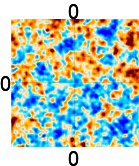

14.753985


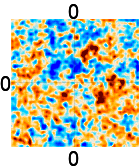

-3.168818


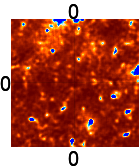

30255739000.0


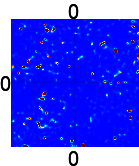

11889438000.0


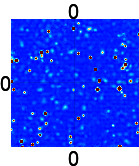

In [7]:
SDS_train = datasets.SehgalDataSet(output_dir, data_type="train_secondary051120", dtype=np.float32)
nplot = 1
_, wcs = maps.rect_geometry(width_arcmin=64., px_res_arcmin=0.5)
for j in range(5):
    print(np.max(SUN(SDS_train[0].copy())[j]))
    enplot.pshow(enmap.enmap(SUN(SDS_train[0].copy())[j], wcs))